### ***Pheno-OptiLIME: faithful local interpretable model-agnostic explanations for phenotypic data***
#### Jupyter notebook containing all code to reproduce the Figures and Tables in the internship report.

##### Run the cell below to import all required Python packages

In [21]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import ast
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phenoscore.explainability_lime.LIME import LIMEConfiguration, OptiLIMEConfiguration
from phenoscore.phenoscorer import PhenoScorer
from Results_generation.Generate_results_per_syndrome import GenerateAndAddResultsToFilePerSyndrome
from scipy.stats import fisher_exact, mannwhitneyu
from sklearn.metrics import accuracy_score, confusion_matrix

The function `plot_sorted_line_charts` plots Figure A.4 of the internship report:

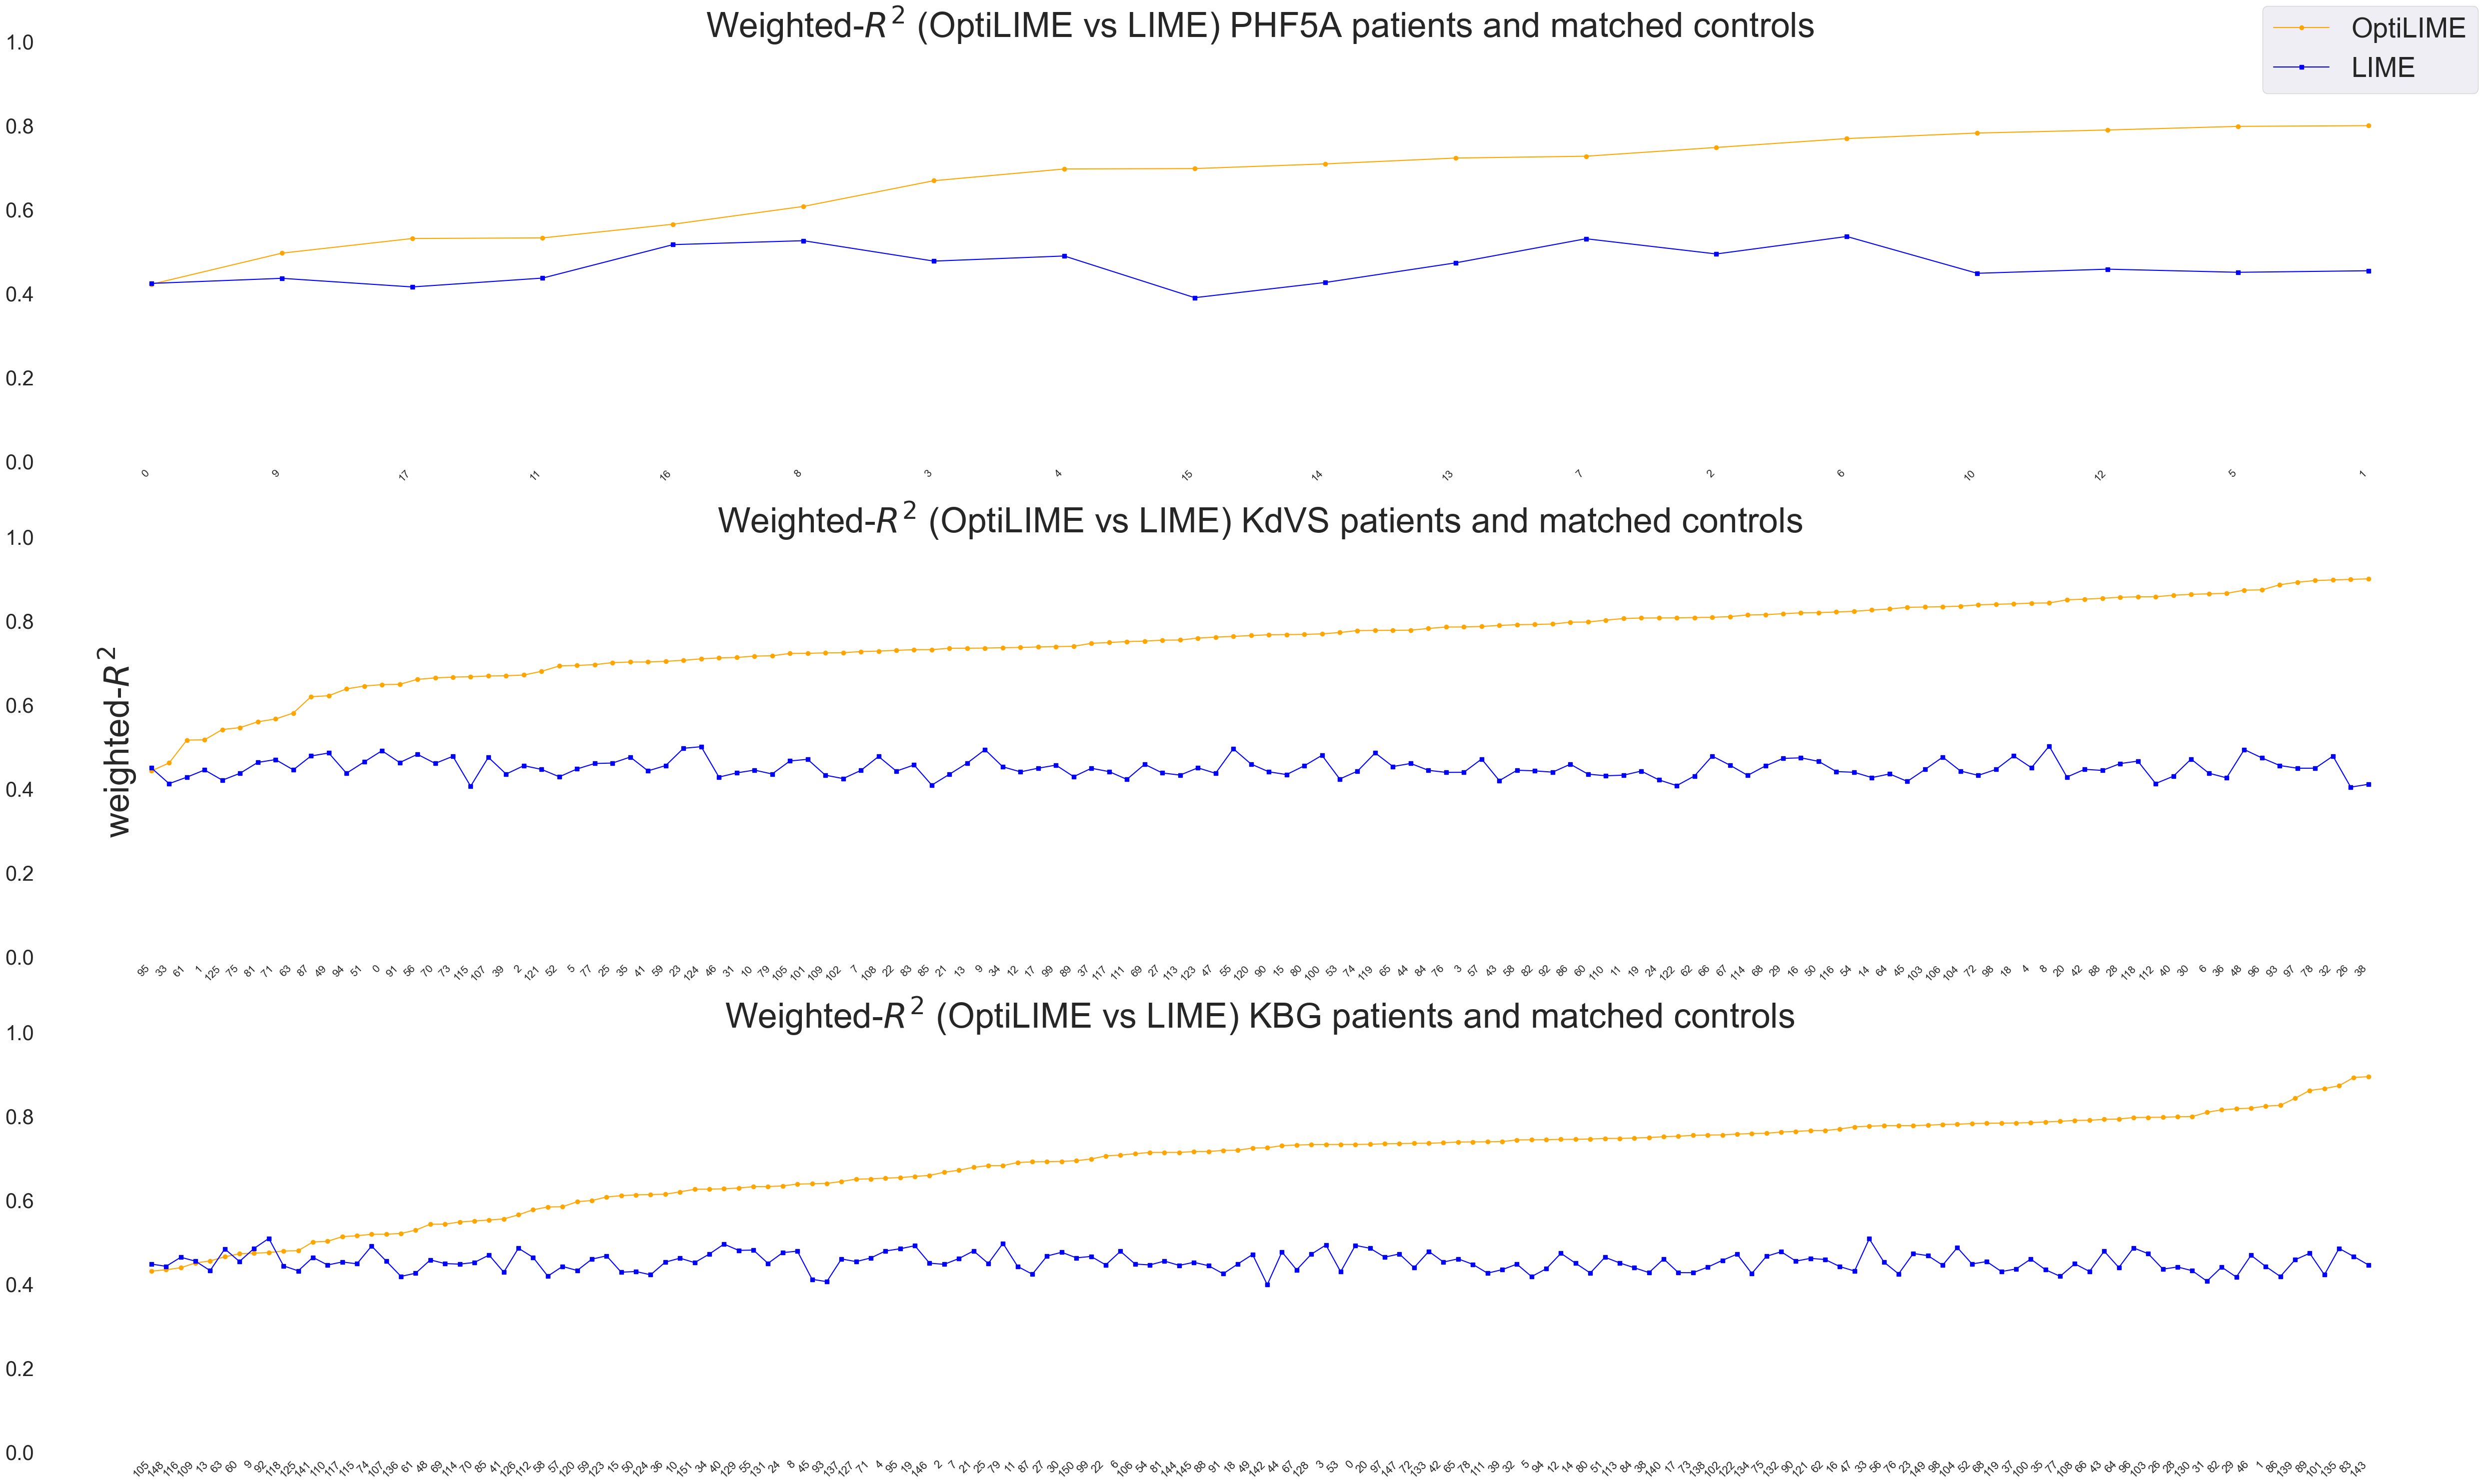

In [22]:
def plot_sorted_line_charts(df_opti, df_lime, syndrome_visual_name, ax):
    """
    This function plots sorted line charts for OptiLIME and LIME data.

    Parameters:
    df_opti (DataFrame): DataFrame containing OptiLIME data.
    df_lime (DataFrame): DataFrame containing LIME data.
    syndrome_visual_name (str): The name of the syndrome for visual representation.
    ax (AxesSubplot): The axes object on which to plot the line chart.

    Returns:
    None
    """
    df_opti.sort_values('weighted R-squared', ascending=True, inplace=True)
    df_lime.set_index('Index').loc[df_opti['Index']].reset_index(inplace=True)

    # Generate positions for each data point
    positions = np.arange(len(df_opti['weighted R-squared']))

    # Plotting the line charts
    ax.plot(positions, df_opti['weighted R-squared'], marker='o', linestyle='-', color='orange', label='OptiLIME')
    ax.plot(positions, df_lime['weighted R-squared'], marker='s', linestyle='-', color='blue', label='LIME')

    ax.set_title(f'Weighted-$R^2$ (OptiLIME vs LIME) {syndrome_visual_name} patients and matched controls', fontsize=50)  # Adjusted font size
    plt.xticks(fontsize=16)
    ax.set_xticks(positions)
    # Set the x-tick labels to the original indices from df_opti
    ax.set_xticklabels(df_opti['Index'], rotation=45, ha='right')  # Adjust rotation and alignment as needed
    ax.set_ylim([0, 1])
    ax.tick_params(axis='y', labelsize=30)  # Adjusted font size
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('none')
    
syndrome_names = ["PHF5A", "KDVS", "KBG"]
visual_names = ['PHF5A', 'KdVS', 'KBG']

fig, axs = plt.subplots(3, figsize=(50, 30))

for i in range(3):
    df_opti = pd.read_excel(f'{syndrome_names[i]}_OptiLIME/{syndrome_names[i]}_OptiLIME_data.xlsx')
    df_lime = pd.read_excel(f'{syndrome_names[i]}_LIME/{syndrome_names[i]}_LIME_data.xlsx')
    plot_sorted_line_charts(df_opti, df_lime, visual_names[i], axs[i])

fig.text(0.05, 0.5, 'weighted-$R^2$', ha='center', va='center', rotation='vertical', fontsize=50)  # Adjusted font size and position
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=40, bbox_to_anchor=(1, 1))  # Adjusted font size and position
plt.tight_layout()
plt.show()

The function `generate_confusion_matrices` plots the individual confusion matrices visibile in figures 5.1, A.1, and A.2 of the internship report.

Explanation fidelity for OptiLIME for PHF5A: 0.94
Explanation fidelity for LIME for PHF5A: 0.61
Explanation accuracy for OptiLIME for PHF5A: 0.83
Explanation accuracy for LIME for PHF5A: 0.61


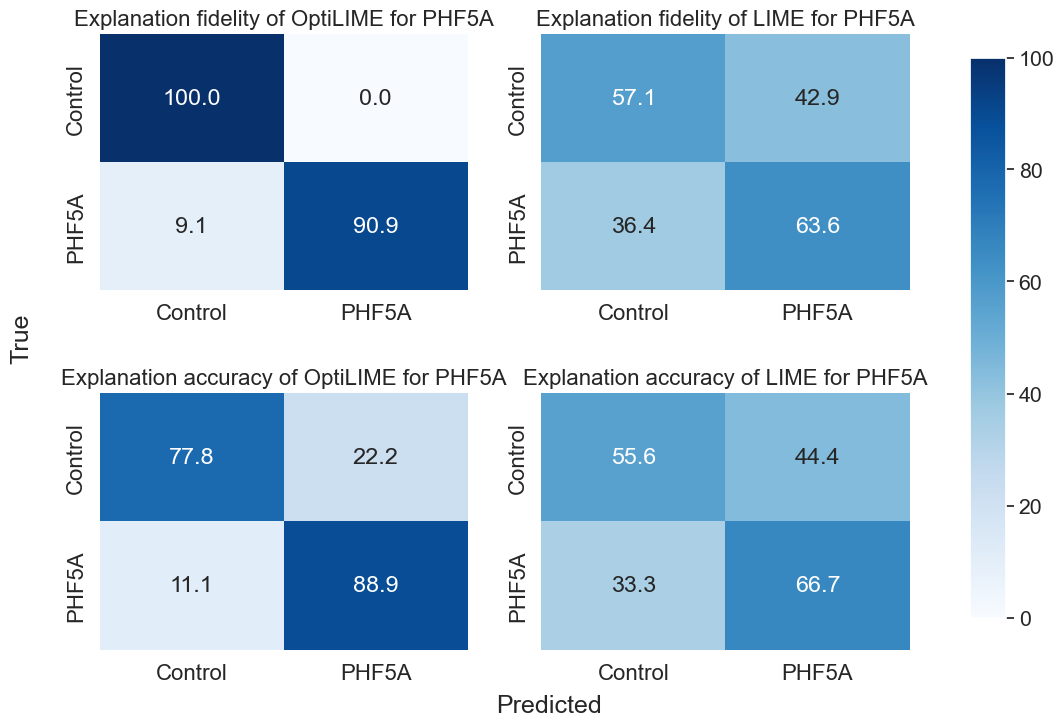

Explanation fidelity for OptiLIME for KdVS: 0.89
Explanation fidelity for LIME for KdVS: 0.67
Explanation accuracy for OptiLIME for KdVS: 0.87
Explanation accuracy for LIME for KdVS: 0.67


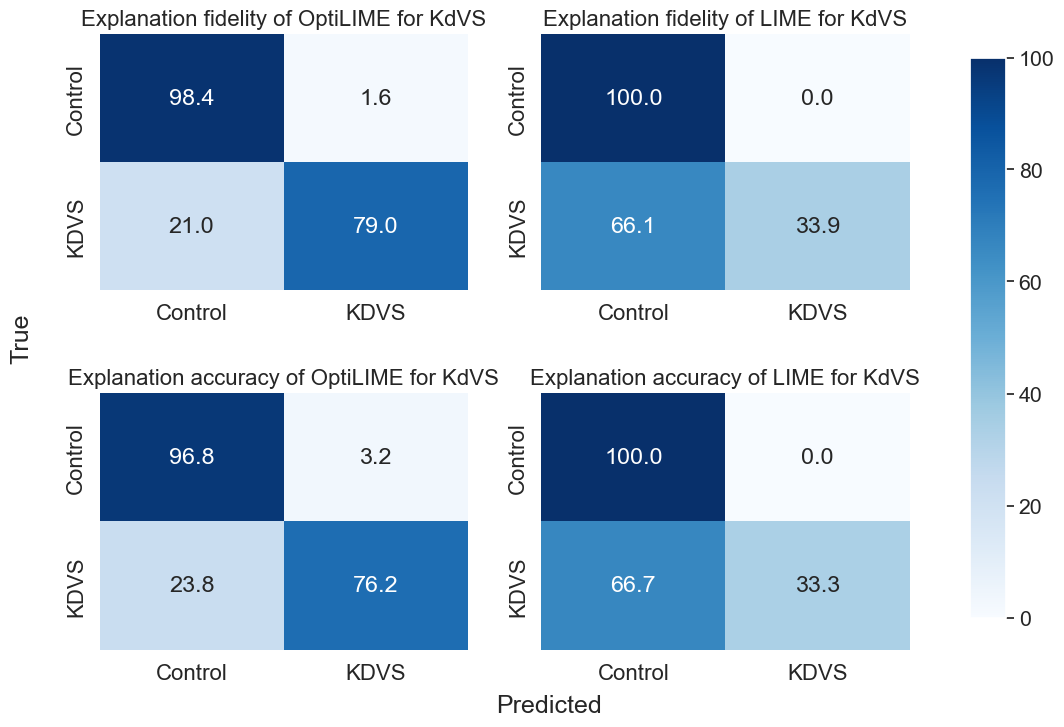

Explanation fidelity for OptiLIME for KBG: 0.85
Explanation fidelity for LIME for KBG: 0.78
Explanation accuracy for OptiLIME for KBG: 0.80
Explanation accuracy for LIME for KBG: 0.72


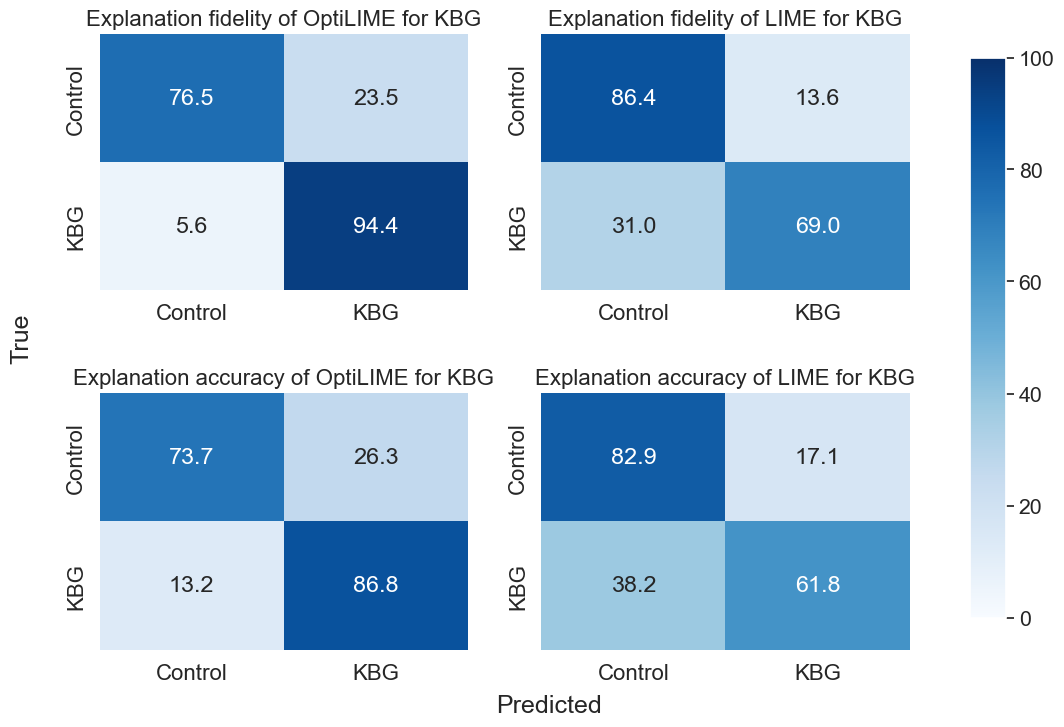

In [23]:
def _calculate_and_plot(df, true_label_col, pred_label_col, method, syndrome, syndrome_plot, metric_type, ax):
    accuracy = accuracy_score(df[true_label_col], df[pred_label_col])
    print(f"{metric_type} for {method} for {syndrome_plot}: {accuracy:.2f}")

    class_names = ['Control', syndrome]
    cm = confusion_matrix(df[true_label_col], df[pred_label_col])
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    sns.set(font_scale=1.4)
    heatmap = sns.heatmap(cm_percentages, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax, 
                norm=mcolors.Normalize(vmin=0, vmax=100), cbar=False)
    ax.set_title(f'{metric_type} of {method} for {syndrome_plot}', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    return heatmap

def generate_confusion_matrices():
    syndrome_names = ["PHF5A", "KDVS", "KBG"]
    visual_names = ['PHF5A', 'KdVS', 'KBG']

    for i in range(3):
        explanation_metrics_path_Opti = f'{syndrome_names[i]}_OptiLIME/{syndrome_names[i]}_OptiLIME_validation.xlsx'
        explanation_metrics_path_LIME = f'{syndrome_names[i]}_LIME/{syndrome_names[i]}_LIME_validation.xlsx'

        df_lime = pd.read_excel(explanation_metrics_path_LIME)
        df_opti = pd.read_excel(explanation_metrics_path_Opti)
        df_lime['classification_LIME'] = np.where(df_lime['sum_coeffs'] >= 0, 1, 0)
        df_opti['classification_OptiLIME'] = np.where(df_opti['sum_coeffs'] >= 0, 1, 0)
        fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.4})

        heatmaps = []
        heatmaps.append(_calculate_and_plot(df_opti, 'classification_PhenoScore', 'classification_OptiLIME', 'OptiLIME', syndrome_names[i], visual_names[i], 'Explanation fidelity', axs[0, 0]))
        heatmaps.append(_calculate_and_plot(df_lime, 'classification_PhenoScore', 'classification_LIME', 'LIME', syndrome_names[i], visual_names[i], 'Explanation fidelity', axs[0, 1]))
        heatmaps.append(_calculate_and_plot(df_opti, 'Y Label', 'classification_OptiLIME', 'OptiLIME', syndrome_names[i], visual_names[i], 'Explanation accuracy', axs[1, 0]))
        heatmaps.append(_calculate_and_plot(df_lime, 'Y Label', 'classification_LIME', 'LIME', syndrome_names[i], visual_names[i], 'Explanation accuracy', axs[1, 1]))

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
        fig.colorbar(heatmaps[0].collections[0], cax=cbar_ax)

        fig.text(0.5, 0.04, 'Predicted', ha='center', va='center', fontsize=18)
        fig.text(0.06, 0.5, 'True', ha='center', va='center', rotation='vertical', fontsize=18)

        plt.show()

generate_confusion_matrices()

The three code block below plot the a) and b) subfigures of Figure 5.2 and A.3 of the internship report. The main function used is `get_top_HPO`.

In [24]:
def get_top_HPO(list_of_hpo_terms, invert_negative_correlations, df_data, avg_predicted_proba):
    """
    Get the top HPO terms from the top 5 PhenoScore predictions (5 runs with controls)

    Parameters
    ----------
    list_of_hpo_terms: list
        List of all generated HPO LIME explanations
    invert_negative_correlations: bool
        Whether to invert the negative correlations (i.e. if something is strongly negatively correlated with class 1,
         it points to class 0). Not useful when investigating individual explanations, but for larger groups (genetic syndromes),
         it provides more information
    df_data: DataFrame
        The DataFrame containing the original HPO terms for all patients and controls
    avg_predicted_proba: float
        The average predicted probability of the top 5 predictions (5 runs with controls, so averaged over 25 predicted probabilities) for the syndrome of interest
    Returns
    -------
    df_summ_hpo: pandas DataFrame
        The top important features
    """

    df_exp_total = pd.DataFrame()

    for exp_hpo in list_of_hpo_terms:
        df_exp_here = pd.DataFrame(exp_hpo.as_list())
        df_exp_here = pd.concat([df_exp_here.iloc[:,0].str.split('=',expand=True), df_exp_here.iloc[:,1]],axis=1)
        df_exp_here.columns = ['hpo', 'positive', 'corr']
        df_exp_total = pd.concat([df_exp_total, df_exp_here]).reset_index(drop=True)

    #now, we can invert all the negative correlations (i.e. if something is strongly negatively correlated with class 1, it points to class 0), since it is a binary classification problem: therefore this will only work with two classes!
    if invert_negative_correlations == True:
        df_exp_total.loc[df_exp_total['positive'] == '0', 'corr'] = -df_exp_total.loc[df_exp_total['positive'] == '0', 'corr']
    df_exp_total['positive'] = df_exp_total['positive'].astype(int)

    if len(list_of_hpo_terms) > 4:
        #only take into account HPO terms that are present in at least 30% predictions, if there are at least 5
        # predictions, otherwise just take them all
        threshold = int(np.round(len(list_of_hpo_terms) * 0.3))

        df_exp_total = df_exp_total[df_exp_total.groupby("hpo")['hpo'].transform('size') > (threshold - 1)]

    df_summ_hpo = df_exp_total.groupby('hpo').mean()
    df_summ_hpo['hpo'] = list(df_summ_hpo.index)

    # if there are more than 10 important features, select the 10 with highest correlations
    df_summ_hpo = df_summ_hpo[df_summ_hpo['hpo'].isin(np.array(abs(df_summ_hpo['corr']).nlargest(10).index))]
    for hpo_term in df_summ_hpo['hpo']:
        df_summ_hpo.loc[hpo_term, 'prev_0'] = df_data.loc[
            df_data['y_label'] == 0, 'hpo_name_inc_parents'].astype(str).str.contains(hpo_term).mean()
        df_summ_hpo.loc[hpo_term, 'prev_1'] = df_data.loc[
            df_data['y_label'] == 1, 'hpo_name_inc_parents'].astype(str).str.contains(hpo_term).mean()


    df_summ_hpo = df_summ_hpo.sort_values(by='corr', ascending=False)

    sum_corr = df_summ_hpo['corr'].sum()
    if sum_corr < 0:
        sum_corr = 0
    else:
        sum_corr = 1


    title_str = f"PhenoScore prediction: {round(avg_predicted_proba, 2)}  Explanation prediction: {sum_corr}"
    fig, axs = plt.subplots(1, 1, figsize=(8, 7))
    axs = np.array([axs])
    # Calculate LIME prediction by calculating the sum of the coefficients
    axs[len(axs) - 1].set_title(title_str, fontsize=18, fontweight='bold')
    fig.patch.set_facecolor('white')
    g = sns.barplot(x=df_summ_hpo['corr'], y=list(df_summ_hpo.index), color='blue', alpha=0.6, ax=axs[len(axs) - 1])

    for bar in g.patches:
        if bar.get_width() < 0:
            bar.set_color('red')
    axs[len(axs) - 1].set_xlim(-0.25, 0.25)
    axs[len(axs) - 1].set_yticks([])
    axs[len(axs) - 1].axes.yaxis.set_visible(False)
    axs[len(axs) - 1].spines['left'].set_visible(False)
    axs[len(axs) - 1].spines['right'].set_visible(False)
    axs[len(axs) - 1].spines['top'].set_visible(False)
    axs[len(axs) - 1].set_xlabel('LIME regression coefficient')
    df_summ_hpo = df_summ_hpo.reset_index(drop=True)
    for y in range(len(df_summ_hpo)):
            axs[len(axs) - 1].text(0, y, df_summ_hpo.loc[y, 'hpo'], fontsize=12, horizontalalignment='center',
                        verticalalignment='center', fontweight='semibold')
            axs[len(axs) - 1].text(-0.28, y, str(int(np.round(df_summ_hpo.loc[y, 'prev_0'] * 100))) + '%', fontsize=12,
                        horizontalalignment='left', verticalalignment='center')
            axs[len(axs) - 1].text(0.28, y, str(int(np.round(df_summ_hpo.loc[y, 'prev_1'] * 100))) + '%', fontsize=12, #' (n = ' + str(df_summ_hpo.loc[y, 'count_1']) + ')'
                        horizontalalignment='right', verticalalignment='center')
    plt.show()
    return df_summ_hpo

In [25]:
syndromes = ['PHF5A','KDVS','KBG']
lime_configs = [('LIME', 'LIME')]
syndrome_predicted_probas = {}

import pandas as pd
for lime_config in lime_configs:
    LIME_type = lime_config[0]
    extra_LIME_type = lime_config[1]
    

    for syndrome in syndromes:
        top_5_preds_per_iteration = [] 
        for i in range(5):
            df = pd.read_excel(fr'{syndrome}_{LIME_type}/{syndrome}_{LIME_type}_{extra_LIME_type}_iteration_{i}.xlsx')
            df = df.dropna(how='any').reset_index(drop=True)
            top_5_indices = list(df['classification_PhenoScore'].nlargest(5).index)
            top_5_preds_per_iteration.append((top_5_indices,i))
        # Get the top 5 LIME explanation objects per iteration
        top_5_per_iteration_explanation = []
        import pickle
        for top_5, i in top_5_preds_per_iteration:
            for index in top_5:
                pickle_path = fr'{syndrome}_{LIME_type}/{syndrome}_{LIME_type}_{extra_LIME_type}_iteration_{i}_index_{index}.pkl'
                with open(pickle_path, 'rb') as f:
                    explanation = pickle.load(f)
                    top_5_per_iteration_explanation.append(explanation)

        # Calculate the average predicted probability for the top 5 predictions
        avg_predicted_proba = np.mean([top_5_per_iteration_explanation[i].predict_proba[1] for i in range(len(top_5_per_iteration_explanation))])
        syndrome_predicted_probas[syndrome] = avg_predicted_proba

Using CPU, since no GPUs are found!


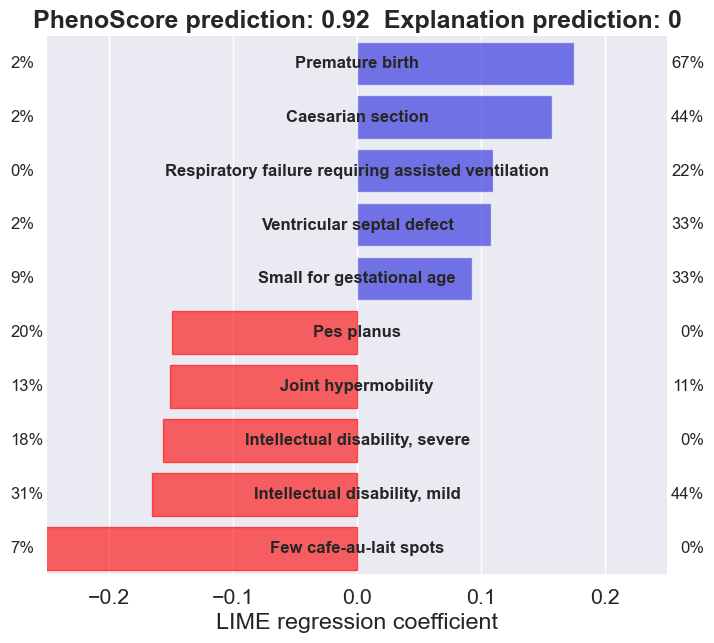

Using CPU, since no GPUs are found!


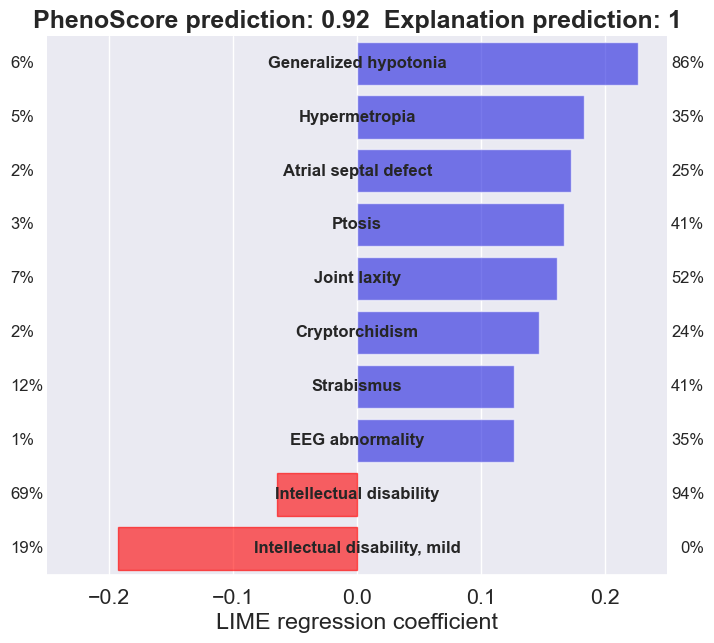

Using CPU, since no GPUs are found!


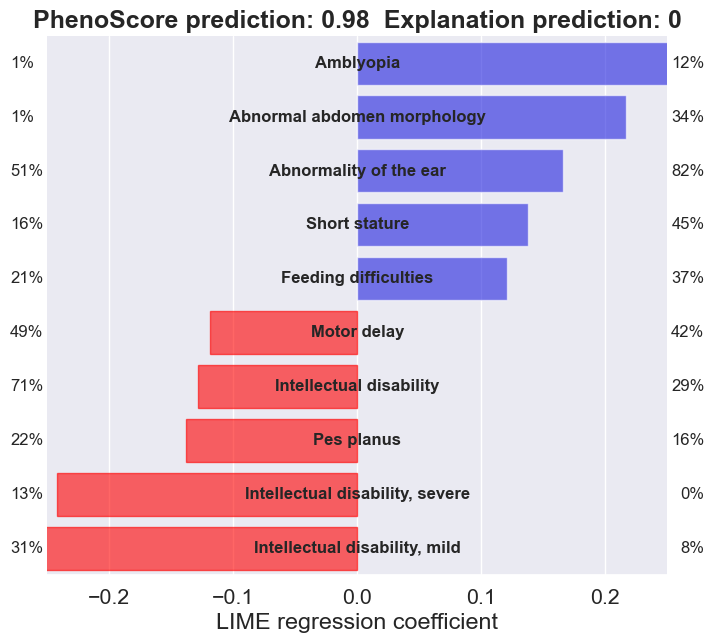

Using CPU, since no GPUs are found!


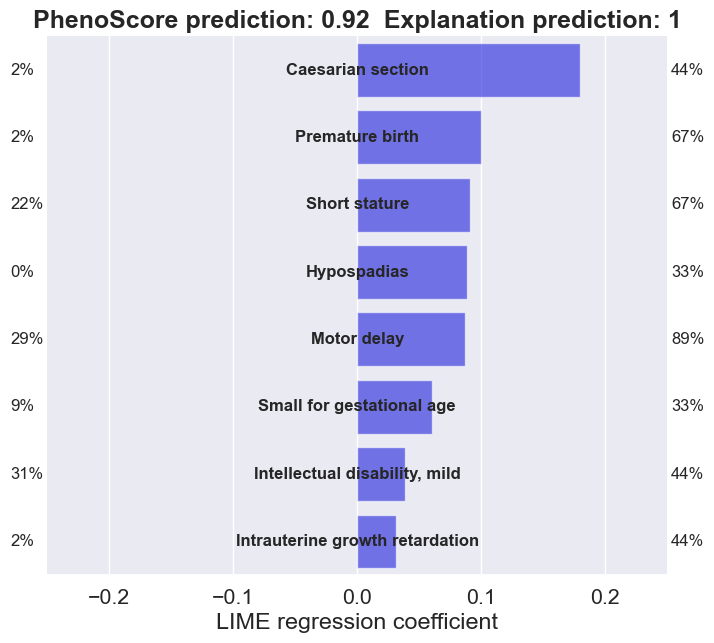

Using CPU, since no GPUs are found!


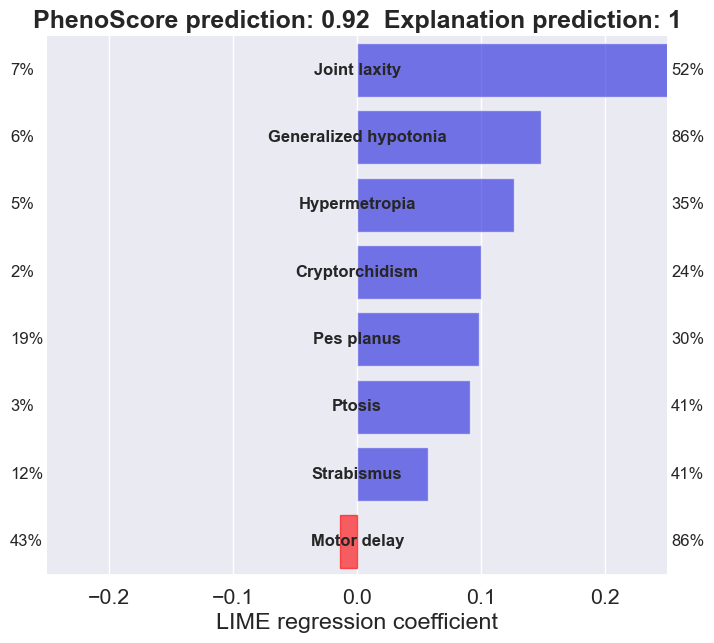

Using CPU, since no GPUs are found!


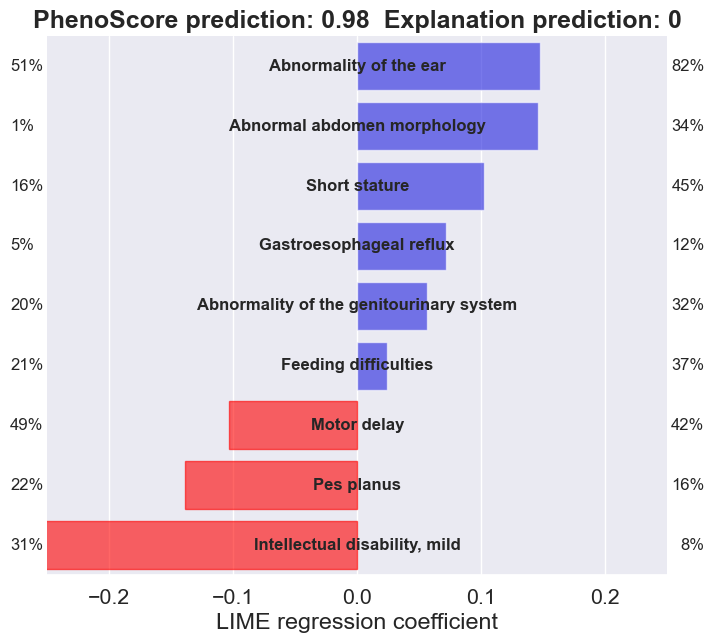

In [26]:
syndromes = ['PHF5A','KDVS','KBG']
lime_configs = [('LIME', 'LIME'), ('OptiLIME', 'PhenoOptiLIME')]
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import pandas as pd
for lime_config in lime_configs:
    LIME_type = lime_config[0]
    extra_LIME_type = lime_config[1]
    

    for syndrome in syndromes:
        top_5_preds_per_iteration = [] 
        for i in range(5):
            df = pd.read_excel(fr'{syndrome}_{LIME_type}/{syndrome}_{LIME_type}_{extra_LIME_type}_iteration_{i}.xlsx')
            df = df.dropna(how='any').reset_index(drop=True)
            top_5_indices = list(df['classification_PhenoScore'].nlargest(5).index)
            top_5_preds_per_iteration.append((top_5_indices,i))
            
        # Get the top 5 LIME explanation objects per iteration
        top_5_per_iteration_explanation = []
        import pickle
        for top_5, i in top_5_preds_per_iteration:
            for index in top_5:
                pickle_path = fr'{syndrome}_{LIME_type}/{syndrome}_{LIME_type}_{extra_LIME_type}_iteration_{i}_index_{index}.pkl'
                with open(pickle_path, 'rb') as f:
                    explanation = pickle.load(f)
                    top_5_per_iteration_explanation.append(explanation)

        #Retrieve the original data to calculate the prevalence of the HPO terms
        phenoscorer = PhenoScorer(gene_name=syndrome, 
                            mode='hpo',
                            method_hpo_similarity='Resnik',
                            method_summ_hpo_similarities='BMA')
        df_data_all = pd.DataFrame()
        for i in range(5):
            X, y, img_paths, df_data = phenoscorer.load_and_process_data_from_excel(fr'\\umcfs020\antrgdata$\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Niels\{syndrome}_hpo_only\{i}\df_data.xlsx')
            df_data_all = pd.concat([df_data_all, df_data])

        get_top_HPO(top_5_per_iteration_explanation, True, df_data_all, syndrome_predicted_probas[syndrome])

Initialize a list and paths to the files containing the data of the patients used in this internship report.

In [27]:
syndromes = ['PHF5A', 'KDVS', 'KBG']

paths = {
    "PHF5A": r"\\umcfs020\antrgdata$\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Niels\data_phf5a.xlsx",
    "KDVS": r"\\umcfs020\antrgdata$\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Niels\kdvs_patient_and_control_matched.xlsx",
    "KBG": r"\\umcfs020\antrgdata$\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Niels\data_kbg_evi.xlsx"
}

The code block below calculates the average weighted-$R^2$, explanation fidelity, explanation accuracy, and kernel width for all four LIME methods. (LIME, Pheno-LIME, OptiLIME, Pheno-OptiLIME)

In [ ]:
configurations = [
    ('LIME', 'euclidean', False),
    ('LIME', 'BMA-Resnik', False),
    ('OptiLIME', 'euclidean', True),
    ('OptiLIME', 'BMA-Resnik', True)
]

def process_syndrome(syndrome, method, distance_metric, optilime):
    lime_config = LIMEConfiguration(perturbed_samples=1000, num_features=10, distance_metric=distance_metric, stability_indices=False)
    optilime_config = OptiLIMEConfiguration(optilime=optilime, maxrsquared=0.9, kw_bounds=np.array([0.01,5]).reshape(1,-1), n_iters=100, n_pre_samples=30)
    if distance_metric == 'BMA-Resnik':
        results_writer = GenerateAndAddResultsToFilePerSyndrome(syndrome, method, paths[syndrome], 'BMA_Resnik', lime_config, optilime_config, False, False)
    else:
        results_writer = GenerateAndAddResultsToFilePerSyndrome(syndrome, method, paths[syndrome], 'debugtest', lime_config, optilime_config, False, False)
    results_writer.generate_results()
    
for method, distance_metric, optilime in configurations:
    for syndrome in syndromes:
        process_syndrome(syndrome, method, distance_metric, optilime)

The code block below calculates the CSI and VSI for all four LIME methods. (LIME, Pheno-LIME, OptiLIME, Pheno-OptiLIME)

In [ ]:
configurations = [
    ('LIME', 'euclidean'),
    ('LIME', 'BMA-Resnik'),
    ('OptiLIME', 'euclidean'),
    ('OptiLIME', 'BMA-Resnik')
]
# OptiLIME is always set to false for computational efficiency, the precomputed kernel width is used from the previous run that calculated the the average weighted R-squared and explanation fidelity/accuracy.
def process_syndrome(syndrome, method, distance_metric):
    lime_config = LIMEConfiguration(perturbed_samples=1000, num_features=10, distance_metric=distance_metric, stability_indices=True)
    optilime_config = OptiLIMEConfiguration(optilime=False, maxrsquared=0.9, kw_bounds=np.array([0.01,5]).reshape(1,-1), n_iters=100, n_pre_samples=30)
    if distance_metric == 'BMA-Resnik':
        results_writer = GenerateAndAddResultsToFilePerSyndrome(syndrome, method, paths[syndrome], 'BMA_Resnik', lime_config, optilime_config, True, True)
    else:
        results_writer = GenerateAndAddResultsToFilePerSyndrome(syndrome, method, paths[syndrome], 'validation', lime_config, optilime_config, True, True)
    results_writer.generate_results()

for method, distance_metric in configurations:
    for syndrome in syndromes:
        process_syndrome(syndrome, method, distance_metric)

The code block below prints the main summary statistics, visible in Table 5.2 of the internship report.

In [ ]:
configurations = [
    ('LIME', 'euclidean', False),
    ('LIME', 'BMA-Resnik', False),
    ('OptiLIME', 'euclidean', True),
    ('OptiLIME', 'BMA-Resnik', True)
]

def process_syndrome(syndrome, method, distance_metric, optilime):
    lime_config = LIMEConfiguration(perturbed_samples=1000, num_features=10, distance_metric=distance_metric, stability_indices=False)
    optilime_config = OptiLIMEConfiguration(optilime=optilime, maxrsquared=0.9, kw_bounds=np.array([0.01,5]).reshape(1,-1), n_iters=100, n_pre_samples=30)
    if distance_metric == 'BMA-Resnik':
        results_writer = GenerateAndAddResultsToFilePerSyndrome(syndrome, method, paths[syndrome], 'BMA_Resnik', lime_config, optilime_config, False, False)
    else:
        results_writer = GenerateAndAddResultsToFilePerSyndrome(syndrome, method, paths[syndrome], 'validation', lime_config, optilime_config, False, False)

    print(f'Results for {method} with the {distance_metric} as distance metric and OptiLIME set to {optilime} for {syndrome}:')
    results_writer.calculate_ci_and_average_metrics(weighted_R_squared='weighted R-squared',VSI='VSI', CSI='CSI')
    results_writer.calculate_ci_and_explanation_fidelity_accuracy(method)
    print('------------------------------------------------')
    
for method, distance_metric, optilime in configurations:
    for syndrome in syndromes:
        process_syndrome(syndrome, method, distance_metric, optilime)

The code block below calculates significance between all combinations of methods using multiple hypothesis testing with Bonferroni correction.

In [28]:
file_paths = [[    'PHF5A_LIME/PHF5A_LIME_validation.xlsx',
    'KDVS_LIME/KDVS_LIME_validation.xlsx',
    'KBG_LIME/KBG_LIME_validation.xlsx',    'PHF5A_LIME/PHF5A_LIME_BMA_Resnik.xlsx',
    'KDVS_LIME/KDVS_LIME_BMA_Resnik.xlsx',
    'KBG_LIME/KBG_LIME_BMA_Resnik.xlsx'],[    'PHF5A_LIME/PHF5A_LIME_validation.xlsx',
    'KDVS_LIME/KDVS_LIME_validation.xlsx',
    'KBG_LIME/KBG_LIME_validation.xlsx',    'PHF5A_OptiLIME/PHF5A_OptiLIME_validation.xlsx',
    'KDVS_OptiLIME/KDVS_OptiLIME_validation.xlsx',
    'KBG_OptiLIME/KBG_OptiLIME_validation.xlsx'],
    [
    'PHF5A_LIME/PHF5A_LIME_validation.xlsx',
    'KDVS_LIME/KDVS_LIME_validation.xlsx',
    'KBG_LIME/KBG_LIME_validation.xlsx',
    'PHF5A_OptiLIME/PHF5A_OptiLIME_BMA_Resnik.xlsx',
    'KDVS_OptiLIME/KDVS_OptiLIME_BMA_Resnik.xlsx',
    'KBG_OptiLIME/KBG_OptiLIME_BMA_Resnik.xlsx'
],['PHF5A_LIME/PHF5A_LIME_BMA_Resnik.xlsx',
    'KDVS_LIME/KDVS_LIME_BMA_Resnik.xlsx',
    'KBG_LIME/KBG_LIME_BMA_Resnik.xlsx','PHF5A_OptiLIME/PHF5A_OptiLIME_validation.xlsx',
    'KDVS_OptiLIME/KDVS_OptiLIME_validation.xlsx',
    'KBG_OptiLIME/KBG_OptiLIME_validation.xlsx'
    ],[  'PHF5A_LIME/PHF5A_LIME_BMA_Resnik.xlsx',
    'KDVS_LIME/KDVS_LIME_BMA_Resnik.xlsx',
    'KBG_LIME/KBG_LIME_BMA_Resnik.xlsx',     'PHF5A_OptiLIME/PHF5A_OptiLIME_BMA_Resnik.xlsx',
    'KDVS_OptiLIME/KDVS_OptiLIME_BMA_Resnik.xlsx',
    'KBG_OptiLIME/KBG_OptiLIME_BMA_Resnik.xlsx'   ],
    ['PHF5A_OptiLIME/PHF5A_OptiLIME_validation.xlsx',
    'KDVS_OptiLIME/KDVS_OptiLIME_validation.xlsx',
    'KBG_OptiLIME/KBG_OptiLIME_validation.xlsx',     
    'PHF5A_OptiLIME/PHF5A_OptiLIME_BMA_Resnik.xlsx',
    'KDVS_OptiLIME/KDVS_OptiLIME_BMA_Resnik.xlsx',
    'KBG_OptiLIME/KBG_OptiLIME_BMA_Resnik.xlsx']]


comparison = ['LIME vs Pheno-LIME', 'LIME vs OptiLIME', 'LIME vs Pheno-OptiLIME','Pheno-LIME vs OptiLIME','Pheno-LIME vs Pheno-OptiLIME','OptiLIME vs Pheno-OptiLIME']
for i, file_path in enumerate(file_paths):
    print(comparison[i])
    dfs = []

    for f in file_path:
        print(f)
        df = pd.read_excel(f)
        if 'OptiLIME' in f:
            df['classification_OptiLIME'] = df['sum_coeffs'].apply(lambda x: 1 if x >= 0 else 0)
            df['exp_fid'] = (df['classification_OptiLIME'] == df['classification_PhenoScore']).astype(int)
            df['exp_acc'] = (df['classification_OptiLIME'] == df['Y Label']).astype(int)
        else:
            df['classification_LIME'] = df['sum_coeffs'].apply(lambda x: 1 if x >= 0 else 0)
            df['exp_fid'] = (df['classification_LIME'] == df['classification_PhenoScore']).astype(int)
            df['exp_acc'] = (df['classification_LIME'] == df['Y Label']).astype(int)
        dfs.append(df)

    columns_of_interest = ['weighted R-squared', 'exp_fid', 'exp_acc']

    results = {}

    for i in range(3):
        syndrome_name = file_path[i].split('_')[0] 
        syndrome_dfs = [dfs[i], dfs[i+3]] 

        for column in columns_of_interest:
            if column in ['exp_fid', 'exp_acc']:
                
                contingency_table = pd.crosstab(syndrome_dfs[0][column], syndrome_dfs[1][column])
                _, p_value = fisher_exact(contingency_table)
                key = f"{syndrome_name}_{column}"
                results[key] = p_value
            else:
                metric_values = [df[column].dropna() for df in syndrome_dfs]
                statistic, p_value = mannwhitneyu(metric_values[0], metric_values[1])
                key = f"{syndrome_name}_{column}"
                results[key] = p_value

    print("Unadjusted p-values:")
    for key, p_value in results.items():
        print(f"{key}: {p_value}")

    m = len(results)
    print(m)

    alpha = 0.05

    alpha_corrected = alpha / m

    print(f"\nBonferroni corrected significance level: {alpha_corrected}")
    significant_tests = {key: p_value < alpha_corrected for key, p_value in results.items()}
    print("\nSignificant tests after Bonferroni correction:")
    for key, is_significant in significant_tests.items():
        print(f"{key}: {'Significant' if is_significant else 'Not Significant'}")
    print('__________________________________________________________')

LIME vs Pheno-LIME
PHF5A_LIME/PHF5A_LIME_validation.xlsx
KDVS_LIME/KDVS_LIME_validation.xlsx
KBG_LIME/KBG_LIME_validation.xlsx
PHF5A_LIME/PHF5A_LIME_BMA_Resnik.xlsx
KDVS_LIME/KDVS_LIME_BMA_Resnik.xlsx
KBG_LIME/KBG_LIME_BMA_Resnik.xlsx
Unadjusted p-values:
PHF5A_weighted R-squared: 0.9873785512460885
PHF5A_exp_fid: 0.00025138260432378077
PHF5A_exp_acc: 0.00025138260432378077
KDVS_weighted R-squared: 0.8784228162766148
KDVS_exp_fid: 3.97269679359308e-34
KDVS_exp_acc: 1.9629795921283455e-34
KBG_weighted R-squared: 0.7605884792897976
KBG_exp_fid: 1.5091608025788509e-23
KBG_exp_acc: 1.7742128873785816e-27
9

Bonferroni corrected significance level: 0.005555555555555556

Significant tests after Bonferroni correction:
PHF5A_weighted R-squared: Not Significant
PHF5A_exp_fid: Significant
PHF5A_exp_acc: Significant
KDVS_weighted R-squared: Not Significant
KDVS_exp_fid: Significant
KDVS_exp_acc: Significant
KBG_weighted R-squared: Not Significant
KBG_exp_fid: Significant
KBG_exp_acc: Significant
